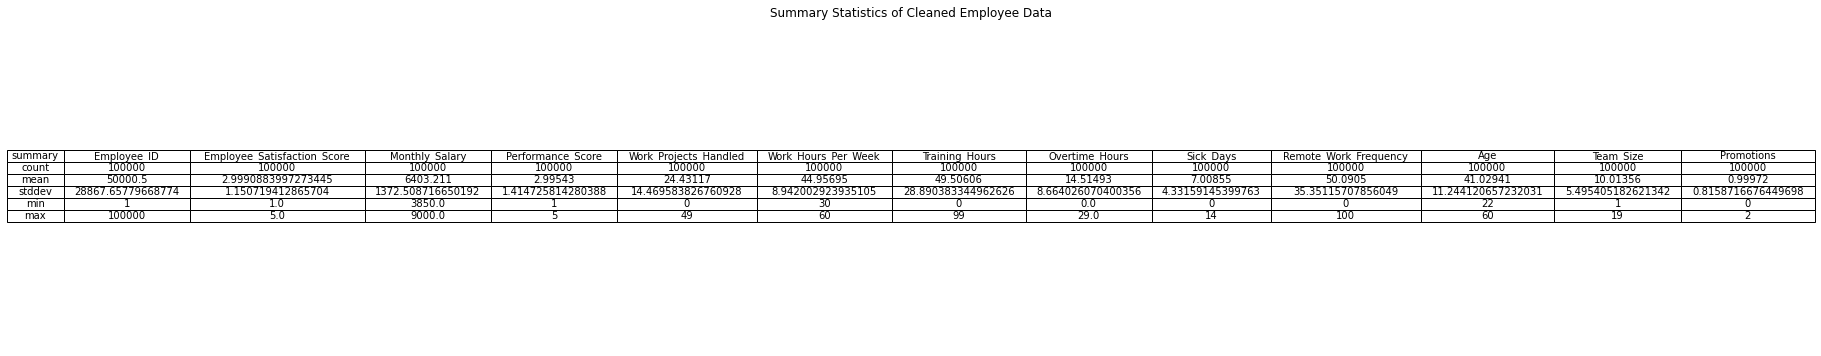

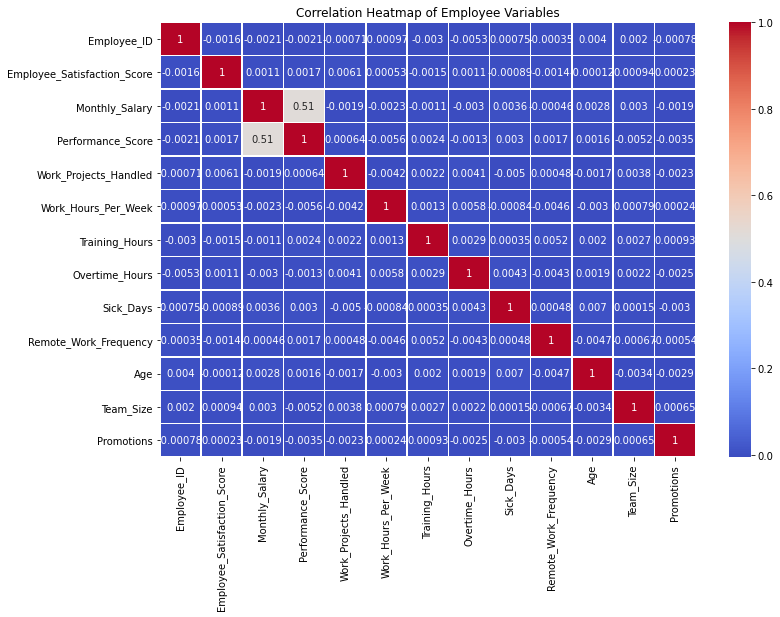

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Starting Spark Session
spark = SparkSession.builder \
    .appName("Employee Analysis") \
    .getOrCreate()

# Loading All Files from HDFS into Spark DataFrames
personal_details_df = spark.read.csv("hdfs://namenode:9000/Employee_Personal_Details.csv", header=True, inferSchema=True)
job_details_df = spark.read.csv("hdfs://namenode:9000/Employee_Job_Details.csv", header=True, inferSchema=True)
work_details_df = spark.read.csv("hdfs://namenode:9000/Employee_Work_Details.csv", header=True, inferSchema=True)
secondary_info_df = spark.read.csv("hdfs://namenode:9000/Employee_Secondary_Information.csv", header=True, inferSchema=True)

# Renaming ambiguous columns (e.g., Projects_Handled) in the joined DataFrames as they had same names
work_details_df = work_details_df.withColumnRenamed("Projects_Handled", "Work_Projects_Handled")
secondary_info_df = secondary_info_df.withColumnRenamed("Projects_Handled", "Secondary_Projects_Handled")

# Joining the Required DataFrames for Analysis
employee_df = personal_details_df \
    .join(job_details_df, on='Employee_ID') \
    .join(work_details_df, on='Employee_ID') \
    .join(secondary_info_df, on='Employee_ID')

# Selecting Required Columns for Analysis and Cast the Data Types
employee_analysis_df = employee_df.select(
    col('Employee_ID'),
    col('Employee_Satisfaction_Score').cast('float'),
    col('Monthly_Salary').cast('float'),
    col('Performance_Score').cast('int'),
    col('Work_Projects_Handled').cast('int'),
    col('Work_Hours_Per_Week').cast('int'),
    col('Training_Hours').cast('int'),
    col('Overtime_Hours').cast('float'),
    col('Sick_Days').cast('int'),
    col('Remote_Work_Frequency').cast('int'),
    col('Age').cast('int'),
    col('Team_Size').cast('int'),
    col('Promotions').cast('int')
)

# Data Cleaning
# Removing rows with null values
employee_analysis_clean_df = employee_analysis_df.na.drop()

# Removing rows with invalid data (e.g., negative values for columns like Work Hours, Salary)
columns_to_check = [
    'Monthly_Salary', 'Work_Projects_Handled', 'Work_Hours_Per_Week', 'Training_Hours',
    'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Age', 'Team_Size', 'Promotions'
]

for column in columns_to_check:
    employee_analysis_clean_df = employee_analysis_clean_df.filter(col(column) >= 0)

# Showing Summary of Cleaned Data
# Calculate summary statistics
summary_df = employee_analysis_clean_df.describe()

# Convert summary to Pandas DataFrame
summary_pandas_df = summary_df.toPandas()

# Plot the summary statistics as a table
plt.figure(figsize=(10, 6))
plt.axis('off')  # Turn off the axes

# Creating a table from the summary dataframe
table = plt.table(cellText=summary_pandas_df.values,
                  colLabels=summary_pandas_df.columns,
                  cellLoc='center',
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_pandas_df.columns))))

plt.title('Summary Statistics of Cleaned Employee Data')
plt.show()

# Converting to Pandas DataFrame for Correlation Analysis
employee_pandas_df = employee_analysis_clean_df.toPandas()

# Calculating the Correlation Matrix
correlation_matrix = employee_pandas_df.corr()

# Plotting Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Employee Variables')
plt.show()


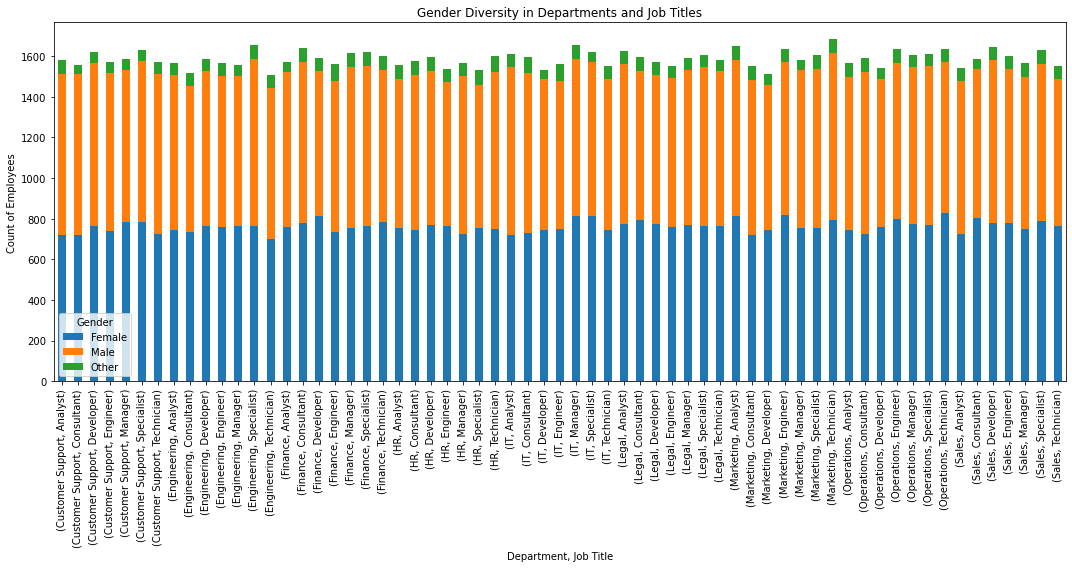

In [2]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

gender_job_df = personal_details_df.join(job_details_df, on='Employee_ID')

# Grouping the data by Department, Job_Title, and Gender, and count the occurrences
gender_distribution_df = gender_job_df.groupBy('Department', 'Job_Title', 'Gender').agg(count('Employee_ID').alias('Gender_Count'))

# Converting the Spark DataFrame to Pandas DataFrame for Visualization
gender_distribution_pandas = gender_distribution_df.toPandas()

# Creating the Stacked Bar Chart for Gender Diversity
pivot_data = gender_distribution_pandas.pivot_table(index=['Department', 'Job_Title'], columns='Gender', values='Gender_Count', fill_value=0)

# distinct colors for each gender
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Stacked bar chart with distinct colors
pivot_data.plot(kind='bar', stacked=True, figsize=(15,8), color=color_palette)  
plt.title('Gender Diversity in Departments and Job Titles')
plt.ylabel('Count of Employees')
plt.xlabel('Department, Job Title')
plt.xticks(rotation=90)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


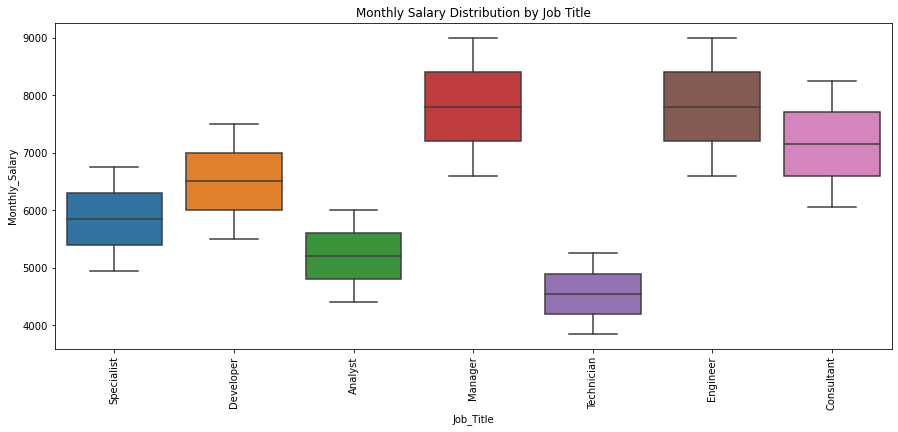

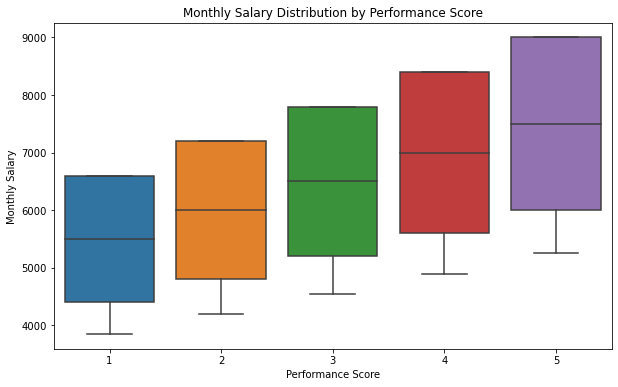

In [3]:

# Join Employee Personal, Job, and Work Details on Employee_ID
salary_df = personal_details_df \
    .join(job_details_df, on='Employee_ID') \
    .join(work_details_df, on='Employee_ID')

# Select relevant columns for salary analysis
salary_analysis_df = salary_df.select(
    'Monthly_Salary',
    'Education_Level',
    'Department',
    'Job_Title',
    'Performance_Score'  
)

# Convert the Spark DataFrame to Pandas for Visualization
salary_analysis_pandas = salary_analysis_df.toPandas()

# Plotting Monthly Salary Analysis

# Boxplot: Salary by Job Title
plt.figure(figsize=(15,6))
sns.boxplot(x='Job_Title', y='Monthly_Salary', data=salary_analysis_pandas)
plt.title('Monthly Salary Distribution by Job Title')
plt.xticks(rotation=90)
plt.show()

# Boxplot: Salary by Performance Score
plt.figure(figsize=(10,6))
sns.boxplot(x='Performance_Score', y='Monthly_Salary', data=salary_analysis_pandas)
plt.title('Monthly Salary Distribution by Performance Score')
plt.xlabel('Performance Score')
plt.ylabel('Monthly Salary')
plt.show()

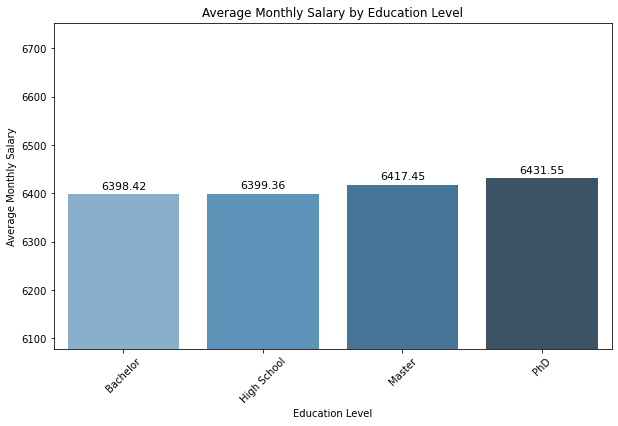

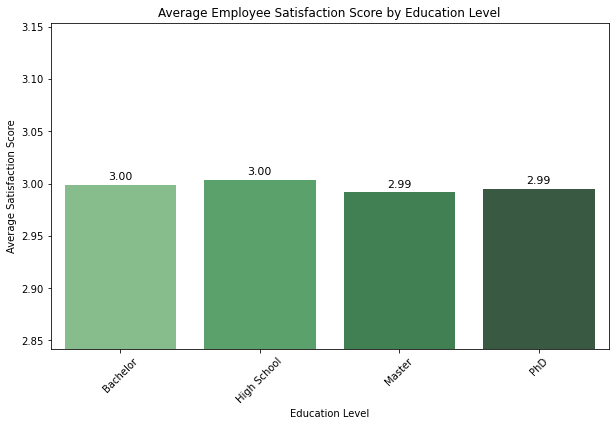

In [4]:
# Joining Employee Personal Details and Work Details on Employee_ID
education_salary_df = personal_details_df.join(work_details_df, on='Employee_ID')

# Selecting relevant columns for education's impact on salary and satisfaction analysis
education_salary_analysis_df = education_salary_df.select(
    'Education_Level',
    col('Monthly_Salary').cast('float'),
    col('Employee_Satisfaction_Score').cast('float')
)

# Converting the Spark DataFrame to Pandas for Visualization
education_salary_pandas = education_salary_analysis_df.toPandas()

# Grouping the data by Education Level and compute average salary and satisfaction score
education_salary_grouped = education_salary_pandas.groupby('Education_Level').agg(
    avg_salary=('Monthly_Salary', 'mean'),
    avg_satisfaction=('Employee_Satisfaction_Score', 'mean')
).reset_index()

# Plotting the results using Bar Charts with Improvements

# Bar chart: Education Level vs Average Monthly Salary
plt.figure(figsize=(10,6))
barplot = sns.barplot(x='Education_Level', y='avg_salary', data=education_salary_grouped, palette='Blues_d')
plt.title('Average Monthly Salary by Education Level')
plt.ylabel('Average Monthly Salary')
plt.xlabel('Education Level')
plt.xticks(rotation=45)

# Adding data labels on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.ylim(education_salary_grouped['avg_salary'].min() * 0.95, education_salary_grouped['avg_salary'].max() * 1.05)  # Adjust y-axis for better visibility
plt.show()

# Bar chart: Education Level vs Average Employee Satisfaction Score
plt.figure(figsize=(10,6))
barplot = sns.barplot(x='Education_Level', y='avg_satisfaction', data=education_salary_grouped, palette='Greens_d')
plt.title('Average Employee Satisfaction Score by Education Level')
plt.ylabel('Average Satisfaction Score')
plt.xlabel('Education Level')
plt.xticks(rotation=45)

# Adding data labels on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.ylim(education_salary_grouped['avg_satisfaction'].min() * 0.95, education_salary_grouped['avg_satisfaction'].max() * 1.05)  # Adjust y-axis for better visibility
plt.show()


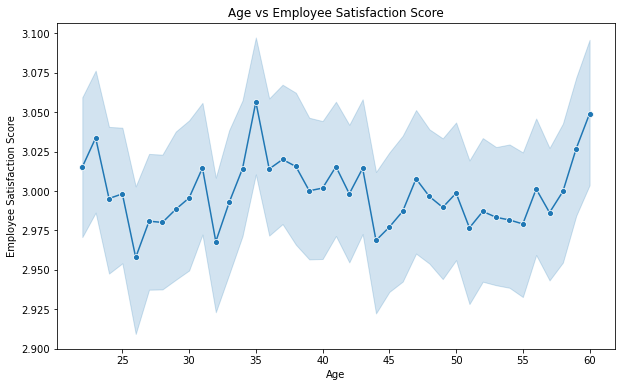

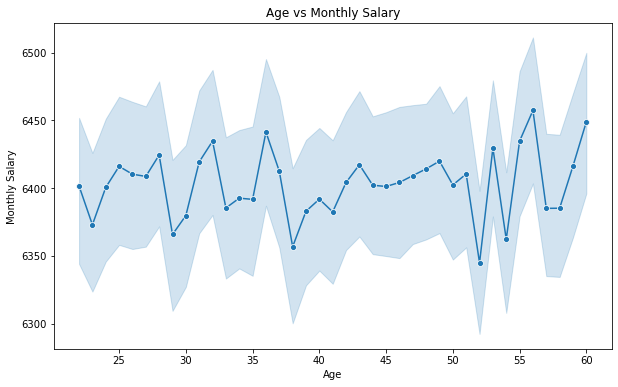

In [5]:
# Joining Employee Personal Details and Work Details on Employee_ID
age_salary_satisfaction_df = personal_details_df.join(work_details_df, on='Employee_ID')

# Selecting relevant columns for age vs satisfaction and salary analysis
age_salary_satisfaction_analysis_df = age_salary_satisfaction_df.select(
    col('Age').cast('int'),
    col('Employee_Satisfaction_Score').cast('float'),
    col('Monthly_Salary').cast('float')
)

# Converting the Spark DataFrame to Pandas for Visualization
age_salary_satisfaction_pandas = age_salary_satisfaction_analysis_df.toPandas()

# Plotting Age vs Employee Satisfaction using a Line Chart

# Line chart: Age vs Employee Satisfaction Score
plt.figure(figsize=(10,6))
sns.lineplot(x='Age', y='Employee_Satisfaction_Score', data=age_salary_satisfaction_pandas, marker='o')
plt.title('Age vs Employee Satisfaction Score')
plt.xlabel('Age')
plt.ylabel('Employee Satisfaction Score')
plt.show()

# Plotting Age vs Monthly Salary using a Line Chart

# Line chart: Age vs Monthly Salary
plt.figure(figsize=(10,6))
sns.lineplot(x='Age', y='Monthly_Salary', data=age_salary_satisfaction_pandas, marker='o')
plt.title('Age vs Monthly Salary')
plt.xlabel('Age')
plt.ylabel('Monthly Salary')
plt.show()


In [6]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, rand

spark.conf.set("spark.sql.execution.arrow.enabled", "false")

# Joining relevant DataFrames on Employee_ID, and rename ambiguous columns
performance_df = job_details_df \
    .join(work_details_df.withColumnRenamed('Projects_Handled', 'Work_Projects_Handled'), on='Employee_ID') \
    .join(secondary_info_df.withColumnRenamed('Projects_Handled', 'Secondary_Projects_Handled'), on='Employee_ID') \
    .select('Employee_ID', 'Performance_Score', 
            'Monthly_Salary', 'Department', 'Job_Title') 

# Selecting relevant columns for performance score prediction
performance_prediction_df = performance_df.select(
    col('Performance_Score').cast('int'), 
    col('Monthly_Salary').cast('float'),
    col('Department').cast('string'),
    col('Job_Title').cast('string')  
)

# Encoding the Department and Job_Title columns using StringIndexer
indexer_department = StringIndexer(inputCol='Department', outputCol='Department_Index').fit(performance_prediction_df)
indexer_job_title = StringIndexer(inputCol='Job_Title', outputCol='Job_Title_Index').fit(performance_prediction_df)

# Applying the indexers to convert Department and Job_Title to numerical form
performance_prediction_df = indexer_department.transform(performance_prediction_df)
performance_prediction_df = indexer_job_title.transform(performance_prediction_df)

# Shuffling the data by ordering it randomly using rand()
shuffled_df = performance_prediction_df.orderBy(rand())

# Assembling features into a single vector column using VectorAssembler (Monthly_Salary, Department, and Job_Title)
assembler = VectorAssembler(
    inputCols=['Monthly_Salary', 'Department_Index', 'Job_Title_Index'],  
    outputCol='features'
)

final_data = assembler.transform(shuffled_df).select('features', 'Performance_Score')

# Spliting the data into training and testing sets after shuffling
train_data, test_data = final_data.randomSplit([0.8, 0.2])

# Initializing RandomForestClassifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Performance_Score')

# Train the model on training data
rf_model = rf_classifier.fit(train_data)

# Make predictions on the test data
test_results = rf_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Performance_Score', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test_results)
print(f"Accuracy: {accuracy}")

# F1 metric as well for more robust evaluation
f1_evaluator = MulticlassClassificationEvaluator(labelCol='Performance_Score', predictionCol='prediction', metricName='f1')
f1 = f1_evaluator.evaluate(test_results)
print(f"F1 Score: {f1}")

# prediction results
test_results.select('Performance_Score', 'prediction').show(20)


Accuracy: 0.8523047504025765
F1 Score: 0.8507498934479885
+-----------------+----------+
|Performance_Score|prediction|
+-----------------+----------+
|                1|       1.0|
|                1|       1.0|
|                2|       2.0|
|                1|       1.0|
|                3|       3.0|
|                3|       3.0|
|                3|       3.0|
|                2|       2.0|
|                2|       2.0|
|                4|       3.0|
|                4|       3.0|
|                4|       3.0|
|                4|       3.0|
|                4|       3.0|
|                1|       1.0|
|                1|       1.0|
|                1|       1.0|
|                3|       3.0|
|                3|       3.0|
|                3|       3.0|
+-----------------+----------+
only showing top 20 rows



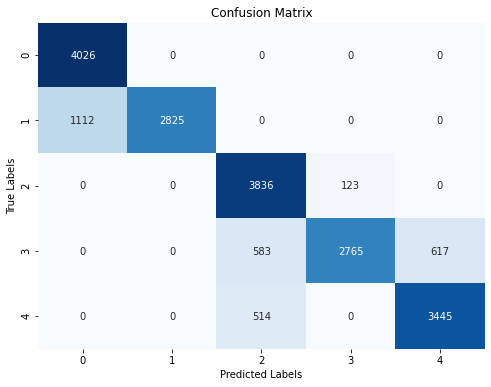

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert test_results to Pandas DataFrame
test_results_pd = test_results.select('Performance_Score', 'prediction').toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(test_results_pd['Performance_Score'], test_results_pd['prediction'])

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


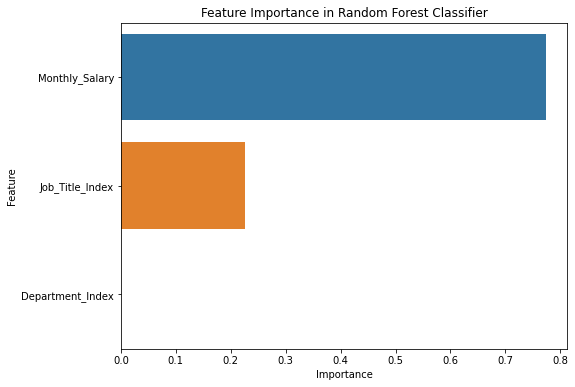

In [8]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.featureImportances

# Convert feature importances to a Pandas DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': ['Monthly_Salary', 'Department_Index', 'Job_Title_Index'],
    'Importance': feature_importances.toArray()
})

# Sort by importance for better visualization
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


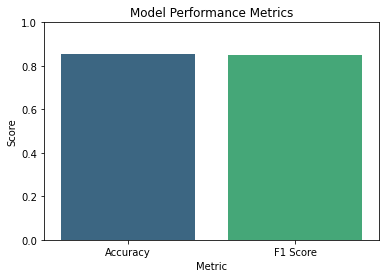

In [9]:
# Create a dataframe with accuracy and F1 scores
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Score': [accuracy, f1]
})

# Plot the performance metrics
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()


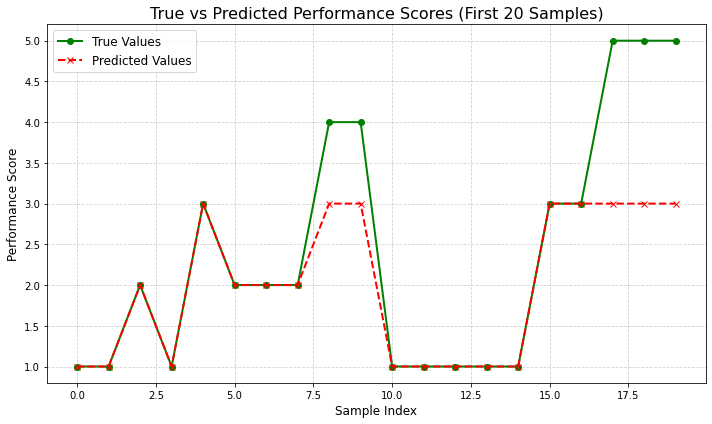

In [10]:
#  visualization for predicted vs actual values
import matplotlib.pyplot as plt

# Plot the first 20 predicted vs actual values for performance score
pred_vs_actual_df = test_results_pd.head(20)

plt.figure(figsize=(10, 6))

# Plot True Values with a solid line
plt.plot(pred_vs_actual_df.index, pred_vs_actual_df['Performance_Score'], 
         label='True Values', marker='o', color='green', linestyle='-', linewidth=2)

# Plot Predicted Values with a dashed line
plt.plot(pred_vs_actual_df.index, pred_vs_actual_df['prediction'], 
         label='Predicted Values', marker='x', color='red', linestyle='--', linewidth=2)

# Add title and axis labels
plt.title('True vs Predicted Performance Scores (First 20 Samples)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Performance Score', fontsize=12)

# Adding a background grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adding legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator

# Renaming ambiguous column 'Projects_Handled' before joining
personal_details_df = personal_details_df.withColumnRenamed('Projects_Handled', 'Personal_Projects_Handled')
secondary_info_df = secondary_info_df.withColumnRenamed('Projects_Handled', 'Secondary_Projects_Handled')

# Joining all relevant DataFrames on Employee_ID
salary_df = personal_details_df \
    .join(job_details_df, on='Employee_ID') \
    .join(work_details_df, on='Employee_ID') \
    .join(secondary_info_df, on='Employee_ID')

# Select relevant columns for salary prediction
salary_prediction_df = salary_df.select(
    col('Monthly_Salary').cast('float'),  # Target variable
    col('Age').cast('int'),
    col('Education_Level').cast('string'),
    col('Department').cast('string'),
    col('Job_Title').cast('string'),
    col('Team_Size').cast('int'),
    col('Resigned').cast('int'),
    col('Performance_Score').cast('int'),
    col('Secondary_Projects_Handled').cast('int').alias('Projects_Handled'),  # Use the renamed column
    col('Work_Hours_Per_Week').cast('int'),
    col('Training_Hours').cast('float'),
    col('Overtime_Hours').cast('float'),
    col('Promotions').cast('int')
)

# Convert categorical columns to numerical indices
indexer_education = StringIndexer(inputCol='Education_Level', outputCol='Education_Index').fit(salary_prediction_df)
indexer_department = StringIndexer(inputCol='Department', outputCol='Department_Index').fit(salary_prediction_df)
indexer_job = StringIndexer(inputCol='Job_Title', outputCol='Job_Title_Index').fit(salary_prediction_df)

# Applying the indexers
salary_prediction_df = indexer_education.transform(salary_prediction_df)
salary_prediction_df = indexer_department.transform(salary_prediction_df)
salary_prediction_df = indexer_job.transform(salary_prediction_df)

# Assemble features into a single vector using VectorAssembler
assembler = VectorAssembler(
    inputCols=['Age', 'Education_Index', 'Department_Index', 'Job_Title_Index',
               'Team_Size', 'Resigned', 'Performance_Score',
               'Projects_Handled', 'Work_Hours_Per_Week', 'Training_Hours',
               'Overtime_Hours', 'Promotions'],
    outputCol='features'
)

final_data = assembler.transform(salary_prediction_df).select('features', 'Monthly_Salary')

# Spliting the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2])

# Initializing and train the Decision Tree Regressor model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Monthly_Salary')

# Fiting the model on the training data
dt_model = dt.fit(train_data)

# Making predictions on the test data
dt_results = dt_model.transform(test_data)


dt_results.select('Monthly_Salary', 'prediction').show()

# Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(labelCol='Monthly_Salary', predictionCol='prediction', metricName='rmse')
dt_rmse = evaluator.evaluate(dt_results)
print(f"Decision Tree Regressor - RMSE: {dt_rmse}")

# R^2 Score
r2_evaluator = RegressionEvaluator(labelCol='Monthly_Salary', predictionCol='prediction', metricName='r2')
dt_r2 = r2_evaluator.evaluate(dt_results)
print(f"Decision Tree Regressor - R2 Score: {dt_r2}")


+--------------+-----------------+
|Monthly_Salary|       prediction|
+--------------+-----------------+
|        9000.0|           9000.0|
|        6300.0|           6300.0|
|        6750.0|           6750.0|
|        5850.0|5620.655239748318|
|        5850.0|5620.655239748318|
|        4950.0|           4950.0|
|        8400.0|           8400.0|
|        4900.0|           4900.0|
|        3850.0|           3850.0|
|        4200.0|           4200.0|
|        4800.0|4998.134894816742|
|        6000.0|           6000.0|
|        6000.0|           6000.0|
|        4400.0|           4400.0|
|        5200.0|4998.134894816742|
|        7200.0|           7200.0|
|        6600.0|6878.617614269788|
|        6600.0|6878.617614269788|
|        7500.0|           7500.0|
|        7500.0|           7500.0|
+--------------+-----------------+
only showing top 20 rows

Decision Tree Regressor - RMSE: 113.65413132048397
Decision Tree Regressor - R2 Score: 0.9931400842855801


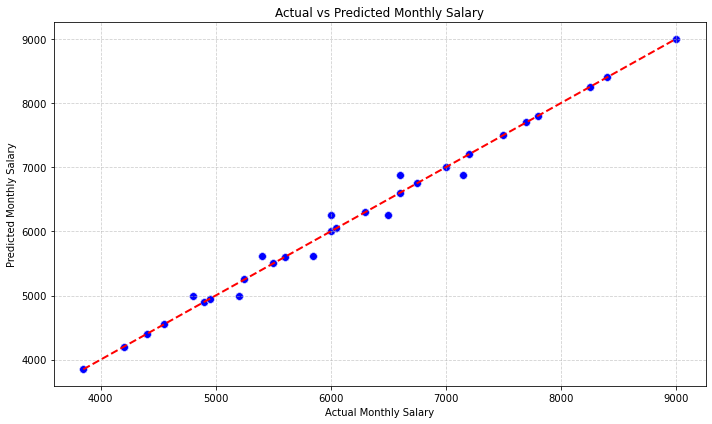

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert test results to Pandas DataFrame for easier visualization
test_results_pd = dt_results.select('Monthly_Salary', 'prediction').toPandas()
plt.figure(figsize=(10, 6))

# Plotting the predicted vs actual values
sns.scatterplot(x=test_results_pd['Monthly_Salary'], y=test_results_pd['prediction'], alpha=0.7, s=60, color='blue')
plt.plot([test_results_pd['Monthly_Salary'].min(), test_results_pd['Monthly_Salary'].max()],
         [test_results_pd['Monthly_Salary'].min(), test_results_pd['Monthly_Salary'].max()],
         color='red', lw=2, linestyle='--')

plt.title('Actual vs Predicted Monthly Salary')
plt.xlabel('Actual Monthly Salary')
plt.ylabel('Predicted Monthly Salary')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


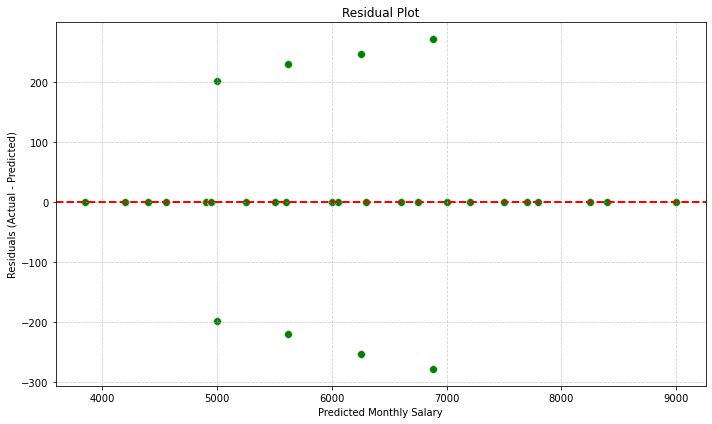

In [13]:
# Calculate residuals
test_results_pd['residuals'] = test_results_pd['Monthly_Salary'] - test_results_pd['prediction']

plt.figure(figsize=(10, 6))

# Plotting the residuals
sns.scatterplot(x=test_results_pd['prediction'], y=test_results_pd['residuals'], alpha=0.7, s=60, color='green')
plt.axhline(0, color='red', lw=2, linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Predicted Monthly Salary')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


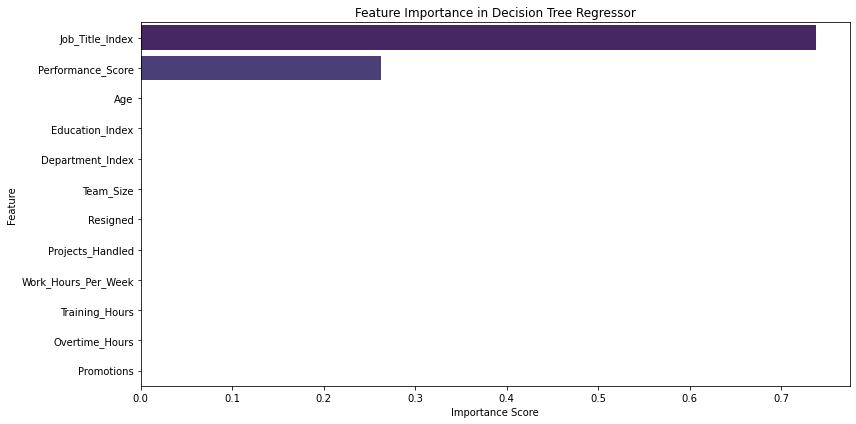

In [14]:
# Extracting feature importances from the trained Decision Tree model
feature_importances = dt_model.featureImportances

# Converting feature importances to a Pandas DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': ['Age', 'Education_Index', 'Department_Index', 'Job_Title_Index',
                'Team_Size', 'Resigned', 'Performance_Score',
                'Projects_Handled', 'Work_Hours_Per_Week', 'Training_Hours',
                'Overtime_Hours', 'Promotions'],
    'Importance': feature_importances.toArray()
})

# Sort feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Decision Tree Regressor')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [15]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col

# Select required columns for clustering with the correct column name for 'Employee_ID'
employee_analysis_df = employee_df.select(
    col('Employee_ID'), 
    col('Age').cast('float'),
    col('Employee_Satisfaction_Score').cast('float'),
    col('Monthly_Salary').cast('float'),
    col('Performance_Score').cast('float'),
    col('Work_Hours_Per_Week').cast('float'),
    col('Work_Projects_Handled').cast('float'),
    col('Training_Hours').cast('float'),
    col('Overtime_Hours').cast('float'),
    col('Sick_Days').cast('float'),
    col('Remote_Work_Frequency').cast('float'),
    col('Team_Size').cast('float'),
    col('Promotions').cast('float')
)

# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=[
        'Age', 'Employee_Satisfaction_Score', 'Monthly_Salary', 'Performance_Score', 
        'Work_Hours_Per_Week', 'Work_Projects_Handled', 'Training_Hours', 
        'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 
        'Team_Size', 'Promotions'
    ],
    outputCol='features'
)

# Transform the DataFrame to include features
employee_features_df = assembler.transform(employee_analysis_df)

# Standardize features to improve clustering performance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
scaler_model = scaler.fit(employee_features_df)
scaled_data = scaler_model.transform(employee_features_df)



In [16]:
# Apply K-means clustering
kmeans = KMeans(featuresCol='scaled_features', k=2, seed=42)  
model = kmeans.fit(scaled_data)

# Make predictions
clusters = model.transform(scaled_data)

# Show the first few rows with cluster assignments
clusters.select('Employee_ID', 'scaled_features', 'prediction').show(10)


+-----------+--------------------+----------+
|Employee_ID|     scaled_features|prediction|
+-----------+--------------------+----------+
|          1|[4.89144519848467...|         0|
|          2|[2.57912565011010...|         0|
|          3|[4.89144519848467...|         1|
|          4|[4.26889762776844...|         1|
|          5|[3.20167322082633...|         1|
|          6|[3.82422079154256...|         0|
|          7|[3.29060858807151...|         0|
|          8|[4.89144519848467...|         1|
|          9|[4.89144519848467...|         1|
|         10|[4.00209152603291...|         1|
+-----------+--------------------+----------+
only showing top 10 rows



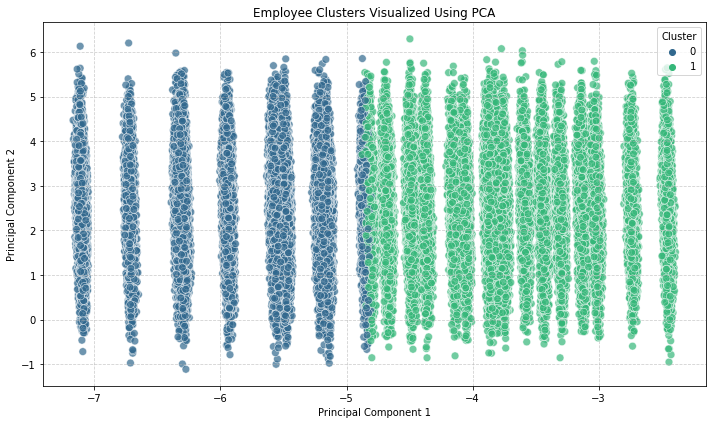

In [17]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
pca_model = pca.fit(clusters)
pca_result = pca_model.transform(clusters)

# Convert to Pandas for visualization
pca_result_pandas = pca_result.select('Employee_ID', 'pca_features', 'prediction').toPandas()

# Extract the PCA features into two separate columns
pca_result_pandas['pca_x'] = pca_result_pandas['pca_features'].apply(lambda x: x[0])
pca_result_pandas['pca_y'] = pca_result_pandas['pca_features'].apply(lambda x: x[1])

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_result_pandas, x='pca_x', y='pca_y', hue='prediction', palette='viridis', s=60, alpha=0.7)
plt.title('Employee Clusters Visualized Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


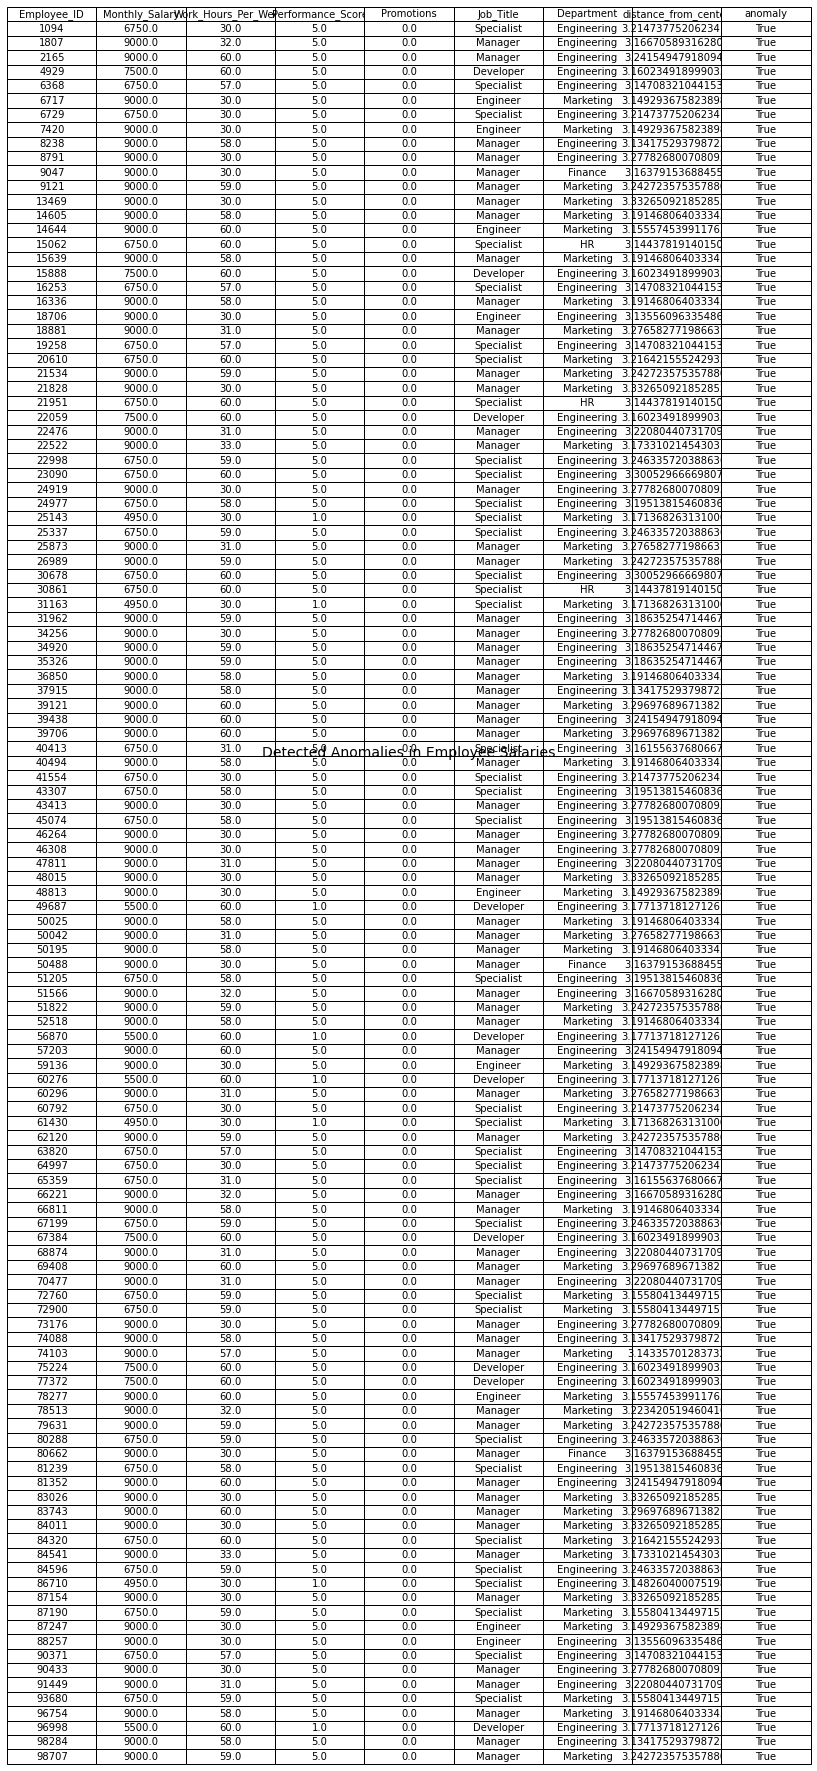

<ipython-input-20-c4c068347f10>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_pd['Employee_ID_numeric'] = anomalies_pd['Employee_ID'].astype(int)


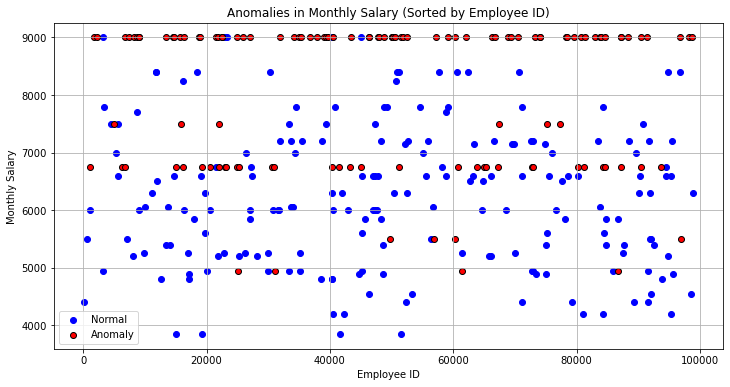

Total number of anomalies: 121


In [20]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
import math
import pandas as pd
import matplotlib.pyplot as plt


employee_salary_df = employee_df.select(
    col('Employee_ID').cast('string'),
    col('Monthly_Salary').cast('double'),
    col('Work_Hours_Per_Week').cast('double'),
    col('Performance_Score').cast('double'),
    col('Promotions').cast('double'),
    col('Job_Title').cast('string'),
    col('Department').cast('string')
)

# Convert categorical columns (Job Title, Department) to numerical values using StringIndexer
indexer_job = StringIndexer(inputCol="Job_Title", outputCol="Job_Title_Index")
indexer_dept = StringIndexer(inputCol="Department", outputCol="Department_Index")

indexed_df = indexer_job.fit(employee_salary_df).transform(employee_salary_df)
indexed_df = indexer_dept.fit(indexed_df).transform(indexed_df)

# Assemble the relevant columns into a feature vector
assembler = VectorAssembler(inputCols=["Monthly_Salary", "Work_Hours_Per_Week", "Performance_Score", "Promotions", "Job_Title_Index", "Department_Index"], outputCol="features")
assembled_df = assembler.transform(indexed_df)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Apply KMeans for anomaly detection
kmeans = KMeans(featuresCol='scaledFeatures', k=3, maxIter=10)  # k=3 means we are modeling with 3 clusters
model = kmeans.fit(scaled_df)

# Make predictions
predictions = model.transform(scaled_df)

# Detect anomalies based on the distance from cluster centers
centers = model.clusterCenters()

def calculate_euclidean_distance(features, center):
    return math.sqrt(sum([(features[i] - center[i]) ** 2 for i in range(len(features))]))

distance_udf = udf(lambda features, pred: calculate_euclidean_distance(features, centers[pred]), DoubleType())
predictions = predictions.withColumn("distance_from_center", distance_udf(col("scaledFeatures"), col("prediction")))


mean_distance = predictions.select("distance_from_center").agg({"distance_from_center": "mean"}).collect()[0][0]
threshold = 1.5 * mean_distance
predictions = predictions.withColumn("anomaly", col("distance_from_center") > threshold)

# Converting to pandas DataFrame for better table display and visualization
predictions_pd = predictions.select("Employee_ID", "Monthly_Salary", "Work_Hours_Per_Week", "Performance_Score", "Promotions", "Job_Title", "Department", "distance_from_center", "anomaly").toPandas()

# Filtering to show only anomalies in the table
anomalies_pd = predictions_pd[predictions_pd['anomaly'] == True]

# Display the anomalies using Matplotlib table
fig, ax = plt.subplots(figsize=(12, 4))  
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = anomalies_pd.values
column_labels = anomalies_pd.columns
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')

# Style the table for readability
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

plt.title('Detected Anomalies in Employee Salaries', fontsize=14, pad=20)
plt.show()

# Sample the data for normal points and include all anomalies
# Adjust the sample size to 200 non-anomalies
normal_data_sample = predictions_pd[predictions_pd['anomaly'] == False].sample(n=200, random_state=42)

# Combine sampled normal data with all anomalies
sampled_data = pd.concat([normal_data_sample, anomalies_pd])

# Convert Employee_ID to numeric for sorting
sampled_data['Employee_ID_numeric'] = sampled_data['Employee_ID'].astype(int)
sampled_data = sampled_data.sort_values('Employee_ID_numeric')

anomalies_pd['Employee_ID_numeric'] = anomalies_pd['Employee_ID'].astype(int)
anomalies_pd = anomalies_pd.sort_values('Employee_ID_numeric')

# Step 12: Visualize the anomalies far from the non-anomalies
plt.figure(figsize=(12, 6))

# Plot non-anomalies in blue (from the larger sample)
plt.scatter(sampled_data[sampled_data['anomaly'] == False]['Employee_ID_numeric'], sampled_data[sampled_data['anomaly'] == False]['Monthly_Salary'], color='blue', label='Normal')

# Plot anomalies in red (all anomalies)
plt.scatter(anomalies_pd['Employee_ID_numeric'], anomalies_pd['Monthly_Salary'], color='red', label='Anomaly', edgecolor='black')

# Add titles and labels
plt.title('Anomalies in Monthly Salary (Sorted by Employee ID)')
plt.xlabel('Employee ID')
plt.ylabel('Monthly Salary')


plt.legend()


plt.grid(True)
plt.show()

# Step 13: Print the total number of anomalies
total_anomalies = len(anomalies_pd)
print(f"Total number of anomalies: {total_anomalies}")
